In [1]:
class Debug:
    def __init__(self, debug=False):
        self.debug = debug

    def log(self, message):
        if self.debug:
            print(">>>" + "=" * 20)
            print(message)
            print("<<<" + "=" * 20)

## [D] 矩阵

$E$ 是弹性模量，$\nu$ 是泊松比。

$$
[D] = \frac{E}{(1-\nu^2)} 
\begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & \frac{1-\nu}{2}
\end{bmatrix}
$$

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import imageio
import os

debug = Debug(debug=False)

nu = 0.5 # 泊松比
E = 30 * 1e6  # 弹性模量
t = 1  # 厚度

D_matrix = (
    E
    / (1 - nu**2)
    * np.array(
        [
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu) / 2],
        ]
    )
)


class TrangleUnion:
    def __init__(self, i, j, m, ix, iy, jx, jy, mx, my):
        self.i = i
        self.j = j
        self.m = m
        self.ix = ix
        self.iy = iy
        self.jx = jx
        self.jy = jy
        self.mx = mx
        self.my = my

        self.A = None
        self.B = None

    def _get_A(self):
        if self.A is not None:
            return self.A
        self.A = (
            np.linalg.det(
                np.array(
                    [
                        [1, self.ix, self.iy],
                        [1, self.jx, self.jy],
                        [1, self.mx, self.my],
                    ]
                )
            )
            / 2
        )
        debug.log(
            f"Area A for triangle {np.array([[1, self.ix, self.iy], [1, self.jx, self.jy], [1, self.mx, self.my]])}: {self.A}"
        )
        return self.A

    def _get_B(self) -> np.ndarray:
        if self.B is not None:
            return self.B

        betai = self.jy - self.my
        betaj = self.my - self.iy
        betam = self.iy - self.jy
        alphai = self.mx - self.jx
        alphaj = self.ix - self.mx
        alpham = self.jx - self.ix

        A = self._get_A()

        if A == 0:
            raise ValueError("The points do not form a valid triangle.")

        self.B = np.array(
            [
                [betai, 0, betaj, 0, betam, 0],
                [0, alphai, 0, alphaj, 0, alpham],
                [alphai, betai, alphaj, betaj, alpham, betam],
            ]
        ) / (2 * A)
        return self.B

    def get_k_matrix(self):
        """
        返回单元刚度矩阵 k
        [ui, vi, uj, vj, um, vm]
        """
        B = self._get_B()

        k = t * self._get_A() * B.T @ D_matrix @ B
        return k

    def update_points(self, dix, diy, djx, djy, dmx, dmy):
        """
        更新三角形的顶点坐标
        """
        self.ix -= dix
        self.iy -= diy
        self.jx -= djx
        self.jy -= djy
        self.mx -= dmx
        self.my -= dmy

        # 清除缓存
        self.A = None
        self.B = None

class Mesh:
    def __init__(self, x_origin, y_origin, xh, yh, xn, yn):
        self.x_origin = x_origin
        self.y_origin = y_origin
        self.xh = xh
        self.yh = yh
        self.xn = xn
        self.yn = yn
        # self.x_array = np.array(range(0, x + h, h))
        # self.y_array = np.array(range(0, y + h, h))
        self.dots_array = np.array(
            [
                [x_origin + i * xh, y_origin + j * yh]
                for i in range(xn + 1)
                for j in range(yn + 1)
            ]
        )
        debug.log(self.dots_array)
        self.x_length = xn + 1
        self.y_length = yn + 1

        k_list = [
            k + i * self.y_length
            for i in range(self.x_length - 1)
            for k in range(self.y_length - 1)
        ]

        self.triangles = [
            TrangleUnion(
                k,
                k + 1,
                k + 1 + self.y_length,
                self.dots_array[k][0],
                self.dots_array[k][1],
                self.dots_array[k + 1][0],
                self.dots_array[k + 1][1],
                self.dots_array[k + 1 + self.y_length][0],
                self.dots_array[k + 1 + self.y_length][1],
            )
            for k in k_list
        ] + [
            TrangleUnion(
                k,
                k + self.y_length,
                k + self.y_length + 1,
                self.dots_array[k][0],
                self.dots_array[k][1],
                self.dots_array[k + self.y_length][0],
                self.dots_array[k + self.y_length][1],
                self.dots_array[k + self.y_length + 1][0],
                self.dots_array[k + self.y_length + 1][1],
            )
            for k in k_list
        ]

        print(f"Mesh created with {len(self.triangles)} triangles.")

        # debug.log("Triangles:")
        for triangle in self.triangles:
            debug.log(
                f"Triangle {triangle.i}, {triangle.j}, {triangle.m}: "
                f"({triangle.ix}, {triangle.iy}), "
                f"({triangle.jx}, {triangle.jy}), "
                f"({triangle.mx}, {triangle.my})"
            )

    def _get_K_matrix(self):
        """
        组装总刚度矩阵 K
        """
        K_matrix = np.zeros((2 * len(self.dots_array), 2 * len(self.dots_array)))

        for triangle in self.triangles:
            k_matrix = triangle.get_k_matrix()
            debug.log(f"Stiffness matrix for triangle {triangle.i}, {triangle.j}, {triangle.m}:")
            debug.log(k_matrix)
            indices = [
                2 * triangle.i,
                2 * triangle.i + 1,
                2 * triangle.j,
                2 * triangle.j + 1,
                2 * triangle.m,
                2 * triangle.m + 1,
            ]
            for i in range(6):
                for j in range(6):
                    K_matrix[indices[i], indices[j]] += k_matrix[i, j]

        debug.log(f"Global stiffness matrix K: {K_matrix}")
        return K_matrix

    def _get_displacement_vector(self, F):
        """
        返回位移向量
        """
        # F 删去前面 y_length 行
        F = F[2 * self.y_length:]

        K_matrix = self._get_K_matrix()
        # K_matrix 删去前面 y_length 行和 y_length 列
        K_matrix = K_matrix[2 * self.y_length:, 2 * self.y_length:]

        # 给 d 添加前面 y_length 列 0
        d = np.zeros(2 * len(self.dots_array))
        d[2 * self.y_length:] = np.linalg.solve(K_matrix, F)

        debug.log(f"Displacement vector d: {d}")
        return d

    def update(self, F):
        """
        更新网格的位移
        """
        self.displacement = self._get_displacement_vector(F)

        for triangle in self.triangles:
            # 更新三角形顶点坐标
            triangle.update_points(
                self.displacement[2 * triangle.i],
                self.displacement[2 * triangle.i + 1],
                self.displacement[2 * triangle.j],
                self.displacement[2 * triangle.j + 1],
                self.displacement[2 * triangle.m],
                self.displacement[2 * triangle.m + 1],
            )

    def plot_mesh(self, save_path=None, plot_type="dots"):
        """
        绘制网格，点颜色表示速度（位移模）
        """
        if plot_type == "dots":
            fig, ax = plt.subplots()
            points_x = []
            points_y = []
            for triangle in self.triangles:
                points_x.extend([triangle.ix, triangle.jx, triangle.mx])
                points_y.extend([triangle.iy, triangle.jy, triangle.my])

            ax.scatter(points_x, points_y, s=0.1, color="black")  # s 控制点的大小

            ax.set_title(save_path)
            ax.set_xlim(-2, 30)
            ax.set_ylim(-2, 30)
            ax.set_aspect("equal", adjustable="box")
            plt.grid()

            if save_path:
                plt.savefig(save_path)
                print(f"Mesh plot saved to {save_path}")
            else:
                plt.show()
        elif plot_type == "lines":
            fig, ax = plt.subplots()
            # 绘制三角形边
            for triangle in self.triangles:
                x = [triangle.ix, triangle.jx, triangle.mx, triangle.ix]
                y = [triangle.iy, triangle.jy, triangle.my, triangle.iy]
                ax.plot(x, y, color="black", linewidth=0.5)  # 描边

            # 可选：绘制顶点
            points_x = []
            points_y = []
            for triangle in self.triangles:
                points_x.extend([triangle.ix, triangle.jx, triangle.mx])
                points_y.extend([triangle.iy, triangle.jy, triangle.my])
            ax.scatter(points_x, points_y, s=0.1, color="red")  # s 控制点的大小

            ax.set_title(save_path)
            ax.set_xlim(-2, 30)
            ax.set_ylim(-2, 30)
            ax.set_aspect("equal", adjustable="box")
            plt.grid()

            if save_path:
                plt.savefig(save_path)
                print(f"Mesh plot saved to {save_path}")
            else:
                plt.show()

    def get_gif(self, save_path, img_list):
        """
        生成 GIF 动画
        """
        images = []
        for img in img_list:
            images.append(imageio.imread(img))
        imageio.mimsave(save_path, images, duration=0.5)
        print(f"GIF saved to {save_path}")

    @staticmethod
    def connect_mesh_x(mesh1: 'Mesh', mesh2: 'Mesh'):
        """
        将两个网格不同尺寸的网格在 x 方向上连接
        """
        if mesh1.y_length % mesh2.y_length != 0 and mesh2.y_length % mesh1.y_length != 0:
            raise ValueError("The y_length of the two meshes must be compatible for connection.")
        
        


class Force:
    """
    dots的排布方式: x = 2, y = 4
    3 7
    2 6
    1 5
    0 4
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.dots_num = x * y
        self.F = np.zeros(2 * self.dots_num)

    def add_force_by_column(self, column, forcex, forcey):
        """
        在指定列添加力
        """
        if type(forcex) is int or type(forcex) is float:
            forcex = np.array([forcex] * self.y)
        if type(forcey) is int or type(forcey) is float:
            forcey = np.array([forcey] * self.y)
        
        for i in range(self.y):
            index = column * self.y + i
            self.F[2 * index] += forcex[i]
            self.F[2 * index + 1] += forcey[i]

Mesh created with 2000 triangles.
Mesh plot saved to ./output/mesh_epoch_1.png
Epoch 1 completed.
Mesh plot saved to ./output/mesh_epoch_2.png
Epoch 2 completed.
Mesh plot saved to ./output/mesh_epoch_3.png
Epoch 3 completed.
Mesh plot saved to ./output/mesh_epoch_4.png
Epoch 4 completed.
Mesh plot saved to ./output/mesh_epoch_5.png
Epoch 5 completed.
Mesh plot saved to ./output/mesh_epoch_6.png
Epoch 6 completed.
Mesh plot saved to ./output/mesh_epoch_7.png
Epoch 7 completed.
Mesh plot saved to ./output/mesh_epoch_8.png
Epoch 8 completed.
Mesh plot saved to ./output/mesh_epoch_9.png
Epoch 9 completed.
Mesh plot saved to ./output/mesh_epoch_10.png
Epoch 10 completed.
Mesh plot saved to ./output/mesh_epoch_11.png
Epoch 11 completed.
Mesh plot saved to ./output/mesh_epoch_12.png
Epoch 12 completed.
Mesh plot saved to ./output/mesh_epoch_13.png
Epoch 13 completed.
Mesh plot saved to ./output/mesh_epoch_14.png
Epoch 14 completed.
Mesh plot saved to ./output/mesh_epoch_15.png
Epoch 15 compl

/var/folders/99/pf4xjtk95tlc4qwhd4nt71s00000gn/T/ipykernel_9312/3097517526.py:295: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(img))


GIF saved to mesh_animation.gif


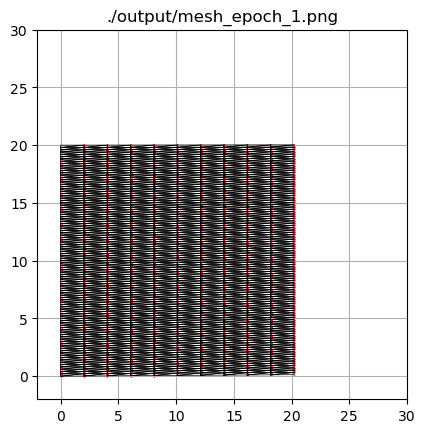

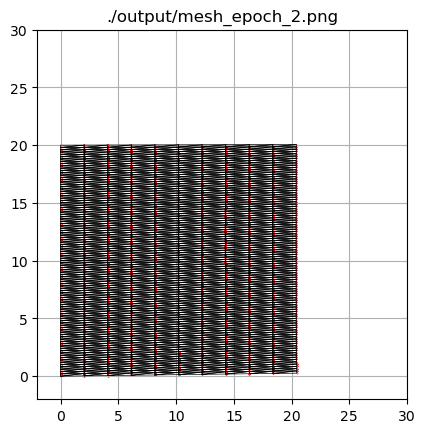

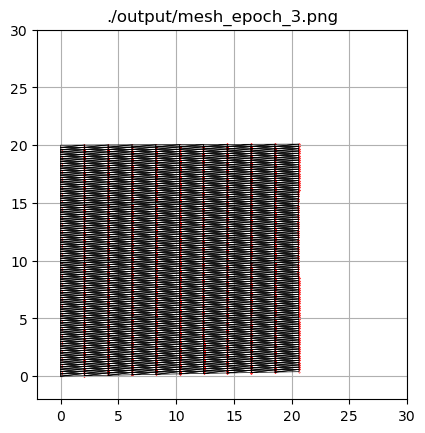

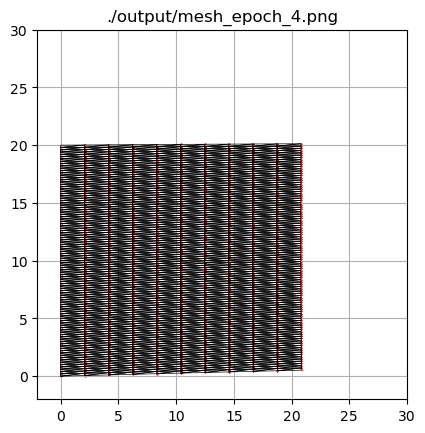

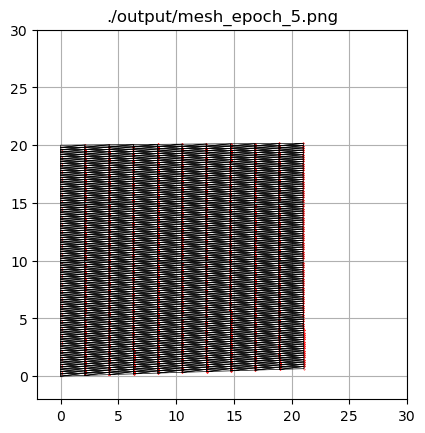

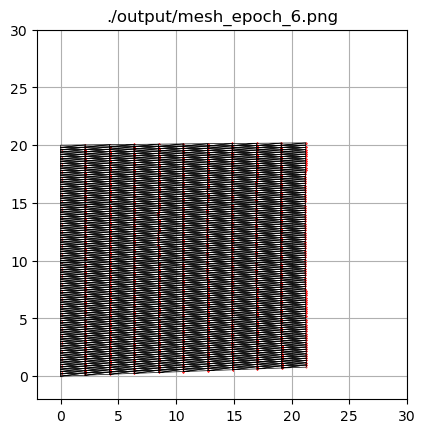

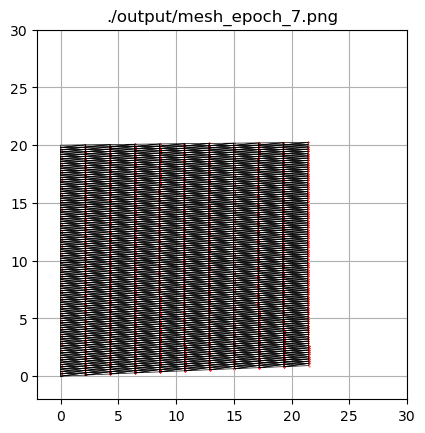

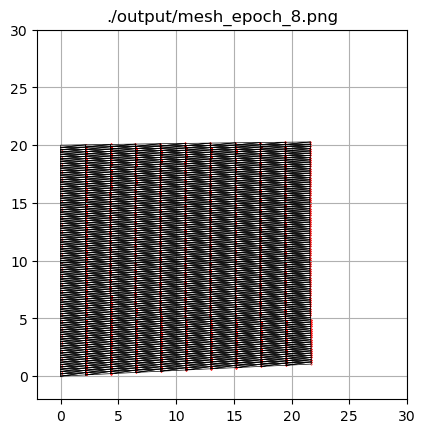

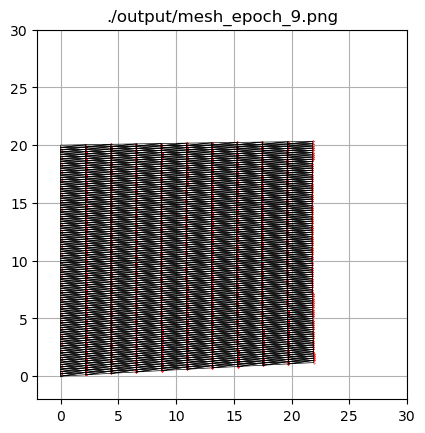

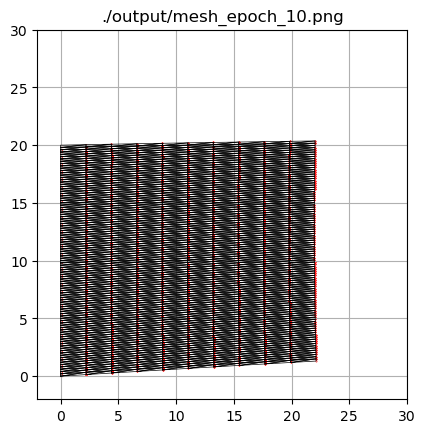

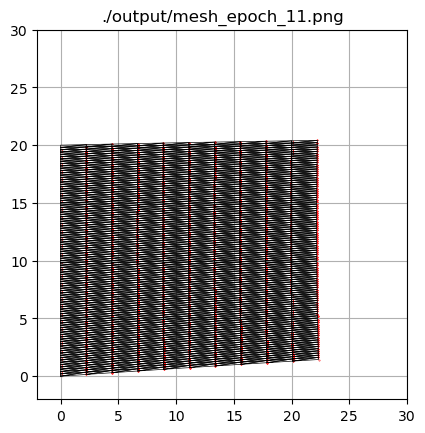

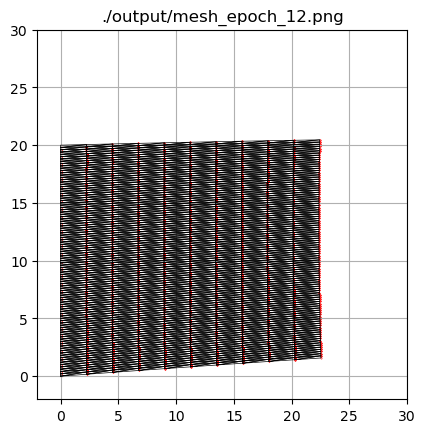

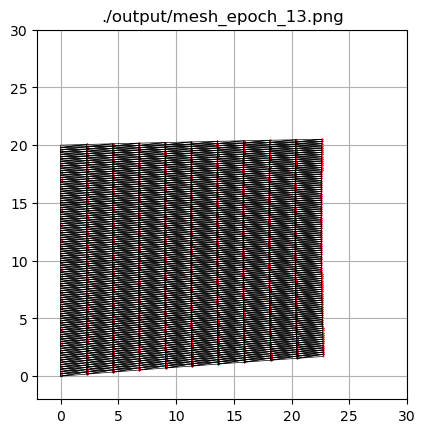

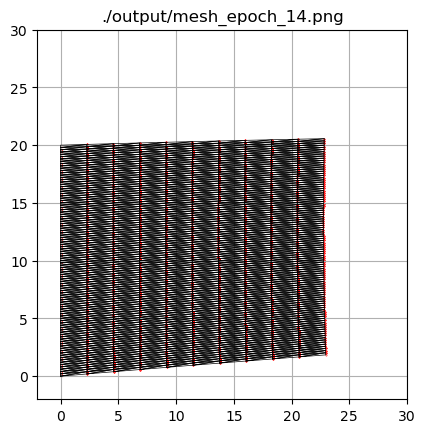

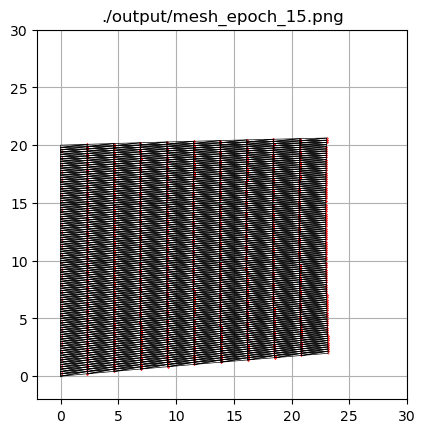

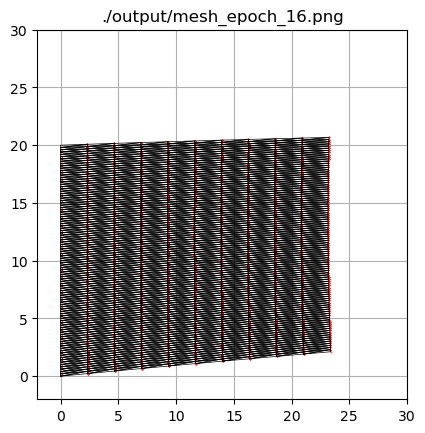

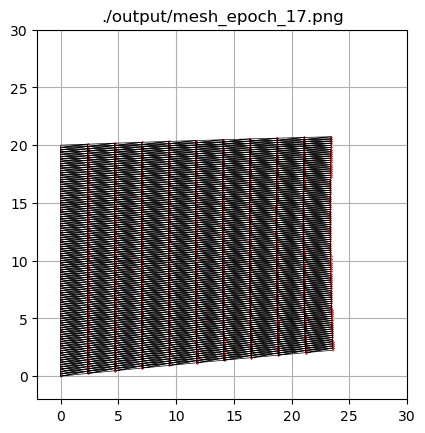

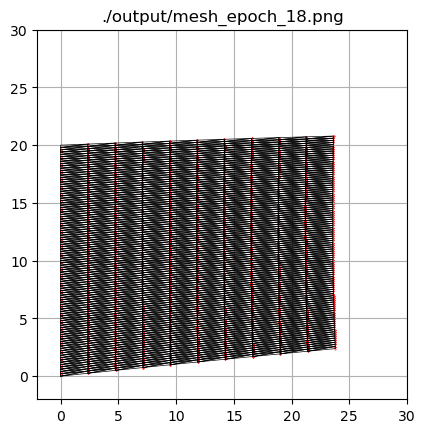

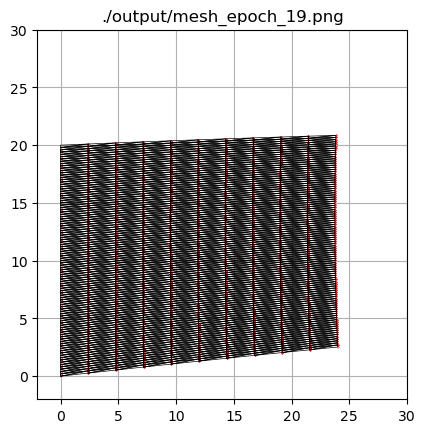

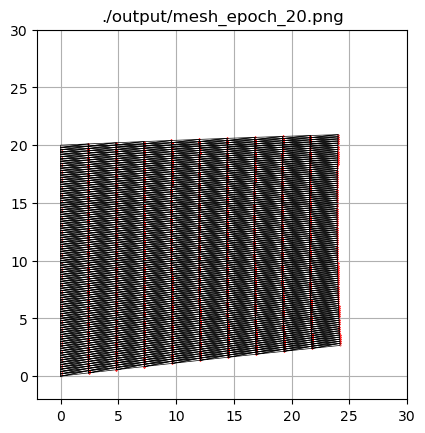

In [3]:
mesh = Mesh(x_origin=0, y_origin=0, xh=2, yh=0.2, xn=10, yn=100)
# mesh = Mesh(0, 0, 1, 1, 2, 2)

# F = Force(mesh.x_length, mesh.y_length)
# 设置边界条件
# F.add_force_by_column(mesh.x_length - 1, np.array([100] + [200] * (mesh.y_length - 2) + [100]), 0)
# F.add_force_by_column(mesh.x_length - 1, 0, -100)
# F.add_force_by_column(mesh.x_length - 1, mesh.y_length - 1, -100)

f_num = [500] * 20
# f_num = [100] * 20

# debug.debug = True
# debug.log("Force vector F: " + str(F.F))
# debug.debug = False

epochs = 20

# debug.log(F)

# mesh.plot_mesh()

os.makedirs("./output", exist_ok=True)

for epoch in range(epochs):
    F = Force(mesh.x_length, mesh.y_length)
    F.add_force_by_column(
        mesh.x_length - 1,
        np.array(
            [f_num[epoch]] + [2 * f_num[epoch]] * (mesh.y_length - 2) + [f_num[epoch]]
        ),
        0,
    )
    mesh.update(F.F)
    mesh.plot_mesh(save_path=f"./output/mesh_epoch_{epoch + 1}.png", plot_type="lines")
    print(f"Epoch {epoch + 1} completed.")

mesh.get_gif(
    "mesh_animation.gif", [f"./output/mesh_epoch_{i + 1}.png" for i in range(epochs)]
)